In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFont, ImageDraw
from scipy.stats import norm
import numpy as np
import random
from string import ascii_letters, digits

In [311]:
# ---------------------------
# 1. Hyperparameters
# ---------------------------
batch_size = 64
image_size = 64
latent_dim = 100
num_epochs = 10
learning_rate_D = 1e-5
learning_rate_G = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [290]:
# ---------------------------
# 2. Custom Dataset Loader (For ./data/train/*.png)
# ---------------------------
class CaptchaDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('1')  # Ensure binary format
        if self.transform:
            image = self.transform(image)
        return image

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((800, 80)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = CaptchaDataset(image_folder="../data/preprocessed_images", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

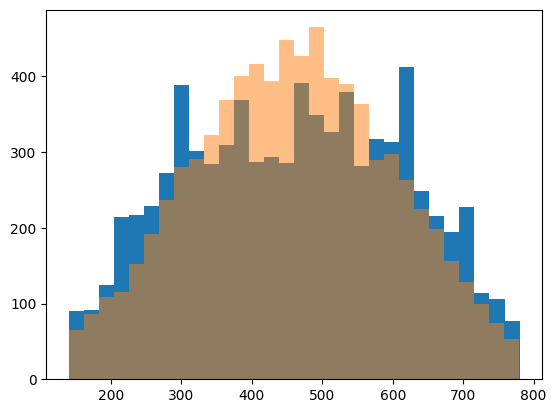

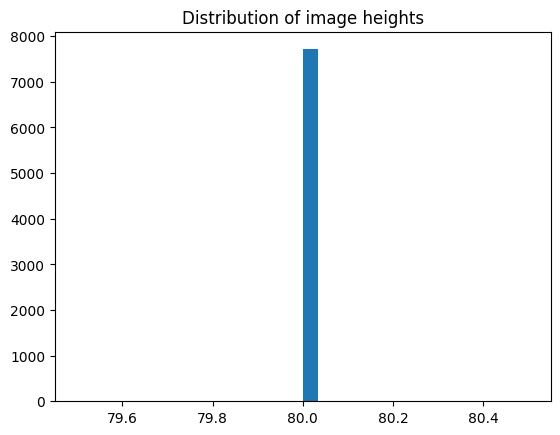

In [283]:
dataset_explore = CaptchaDataset(image_folder="../data/preprocessed_images", transform=None)
# plot image dimensions distribution in the dataset
widths = list(map(lambda image: image.size[0], dataset_explore))
plt.hist(widths, bins=30)

# fit a normal distribution to the data
min_width = min(widths)
max_width = max(widths)
mu, std = norm.fit(widths)

# sample and compare
sampled_widths = norm.rvs(mu, std, 8000)
sampled_widths = sampled_widths[(sampled_widths >= min_width) & (sampled_widths <= max_width)]
plt.hist(sampled_widths, bins=30, alpha=0.5)
plt.show()


heights = list(map(lambda image: image.size[1], dataset))
plt.hist(heights, bins=30)
plt.title("Distribution of image heights")
plt.show()

### Captcha generation pipeline
Use PIL to generate a captcha image of size (w, 80)
where w is sampled using normal distribution params obtained above

For each image, randomly choose these params:
1. width: image width sampled from distribution above
1. font: text font in a captcha, random chosen in a pre-defined subset.
    - TODO: generate captcha that contains more than 1 font
1. font_size: font size of each letter
1. gap: (expected) spearation between each 2 letters
1. center_height: (expected) central height of letters

For each character in the image, randomly choose these params:
1. char: the character itself, in alphanumeric
1. x_displacement: small horizontal displacement
1. y_displacement: small vertical displacement
1. rotation: anticlockwise rotation in degrees

Use these params to draw letters in binary format until right margin

In [314]:
# Known values
MU = mu
STD = std
MIN_WIDTH = min_width
MAX_WIDTH = max_width
print(f"mu: {MU}, std: {STD}, min_width: {MIN_WIDTH}, max_width: {MAX_WIDTH}")

LEFT_MARGIN = 30 # if x position is below this value, regenerate

HEIGHT = 80
FONT_FILENAMES = [f for f in os.listdir("./fonts") if f.endswith('.ttf')]
FONTSIZE_MIN = 24
FONTSIZE_MAX = 40
GAP_MIN = 5 # should not be too high, need some overlap
GAP_MAX = 30

X_DISPLACEMENT_MIN = -5
X_DISPLACEMENT_MAX = 5
Y_DISPLACEMENT_MIN = -5
Y_DISPLACEMENT_MAX = 5
ROTATION_MIN = -20
ROTATION_MAX = 20

ALPHANUMERIC = ascii_letters + digits

mu: 459.92156100090756, std: 154.64145619671635, min_width: 140, max_width: 780


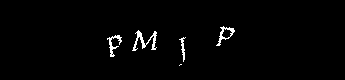

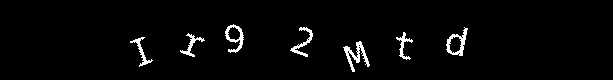

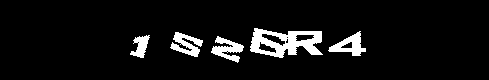

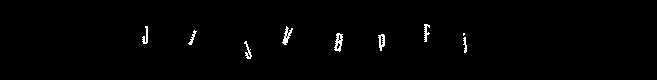

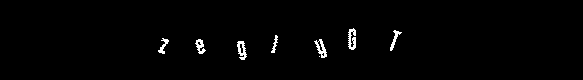

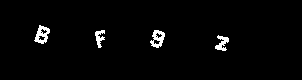

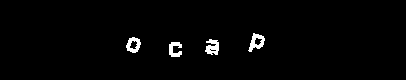

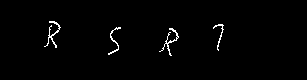

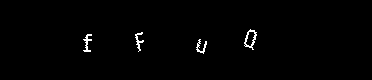

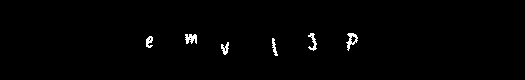

In [320]:
def get_random_width(mu, std, min_width, max_width):
    w = int(norm.rvs(mu, std))
    if w >= min_width and w <= max_width:
        return w
    return get_random_width(mu, std, min_width, max_width)
    

def generate_random_captcha():
    width = get_random_width(MU, STD, MIN_WIDTH, MAX_WIDTH)
    height = HEIGHT
    font_size = random.randint(FONTSIZE_MIN, FONTSIZE_MAX)
    font = ImageFont.truetype("./fonts/" + random.choice(FONT_FILENAMES), font_size)
    gap = random.randint(GAP_MIN, GAP_MAX)
    center_height = random.randint(HEIGHT // 20 * 9, HEIGHT // 20 * 11)
    
    # Approximation for the number of characters
    # TODO: check distribution of num characters generated and change this if needed
    num_chars = max(min((width - LEFT_MARGIN * 2) // 70, 9), 4)

    img = Image.new('1', (width, height))
    for i in range(num_chars):
        # Draw a character (pun intended)
        char = random.choice(ALPHANUMERIC)

        expected_x_disp_in_characters_from_center = i - num_chars / 2
        expected_x_start = width / 2 + (font_size + gap) * expected_x_disp_in_characters_from_center

        # TODO: check distribution, change random function if needed (e.g. with some probability it should not have any displ or rotation)
        x_displacement = random.randint(X_DISPLACEMENT_MIN, X_DISPLACEMENT_MAX)
        y_displacement = random.randint(Y_DISPLACEMENT_MIN, Y_DISPLACEMENT_MAX)
        rotation = random.randint(ROTATION_MIN, ROTATION_MAX)

        x_start = int(expected_x_start + x_displacement)
        char_height = font.getmetrics()[0] + font.getmetrics()[1] # ascent + descent
        y_start = int(center_height - char_height / 2 + y_displacement)

        # regenerate if out of bounds
        if x_start < LEFT_MARGIN:
            return generate_random_captcha()
        elif y_start + char_height > height or y_start < 0:
            return generate_random_captcha()

        text_img = Image.new('L', (char_height, char_height))
        text_draw = ImageDraw.Draw(text_img)
        text_draw.text((0, 0), char, font=font, fill=255, spacing=0)
        text_img = text_img.rotate(rotation, expand=True)
        img.paste(text_img, (x_start, y_start), text_img)

    return img

for i in range(10):
    img = generate_random_captcha()
    display(img)

In [312]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, feature_g=64):
        super(Generator, self).__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, feature_g, 3, 1, 1),
            nn.ReLU()
        )

        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                nn.BatchNorm2d(feature_g),
                nn.ReLU(),
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                nn.BatchNorm2d(feature_g)
            )
         for _ in range(4)])

        self.final = nn.Sequential(
            nn.Conv2d(feature_g, img_channels, 1, 1, 0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        for b in self.residual_blocks:
            x = x + b(x)
        x = self.final(x)
        return x
        

class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 8, 1, 4, 1, 0, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))

In [313]:
for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        real_imgs = images.to(device)
        b_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(b_size, 1, device=device)
        fake_labels = torch.zeros(b_size, 1, device=device)

        # ---- Train Discriminator ----
        netD.zero_grad()
        
        # Real images
        output_real = netD(real_imgs).view(-1, 1)
        lossD_real = criterion(output_real, real_labels)

        # Fake images
        fake_imgs = [transform(generate_random_captcha()) for _ in range(b_size)]
        fake_imgs = torch.stack(fake_imgs).reshape(b_size, 1, 80, 800).to(device)
        fake_imgs = netG(fake_imgs) # go through generator to apply pixel-level adjustments
        output_fake = netD(fake_imgs.detach()).view(-1, 1)
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()
        
        # Try to fool the discriminator
        output_fake_for_G = netD(fake_imgs).view(-1, 1)
        lossG = criterion(output_fake_for_G, real_labels)
        lossG.backward()
        optimizerG.step()

        if i % 1 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

Epoch [0/10] Batch 0/121 Loss D: 1.2652, Loss G: 1.0217
Epoch [0/10] Batch 1/121 Loss D: 1.2786, Loss G: 0.9688
Epoch [0/10] Batch 2/121 Loss D: 1.2041, Loss G: 1.0693
Epoch [0/10] Batch 3/121 Loss D: 1.1406, Loss G: 1.1331
Epoch [0/10] Batch 4/121 Loss D: 1.0634, Loss G: 1.2291
Epoch [0/10] Batch 5/121 Loss D: 1.0109, Loss G: 1.2913
Epoch [0/10] Batch 6/121 Loss D: 1.0502, Loss G: 1.1278


KeyboardInterrupt: 